<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/main/recipes/geojson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Converting GeoJSON data to Kili label format

In this recipe, we will show you how to convert GeoJSON data to Kili label format and vice versa.

First, let's install and import the required libraries:

In [ ]:
%pip install kili wget

In [ ]:
import json

from kili.client import Kili

In [ ]:
kili = Kili()

## Data

For this tutorial, we will use a GeoTiff file created from Copernicus Sentinel-2A data

In [ ]:
!wget https://github.com/mommermi/geotiff_sample/raw/master/sample.tif

--2023-07-12 15:16:51--  https://github.com/mommermi/geotiff_sample/raw/master/sample.tif
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mommermi/geotiff_sample/master/sample.tif [following]
--2023-07-12 15:16:51--  https://raw.githubusercontent.com/mommermi/geotiff_sample/master/sample.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6018396 (5,7M) [application/octet-stream]
Saving to: ‘sample.tif’

sample.tif          100%[===================>]   5,74M  --.-KB/s    in 0,1s    

2023-07-12 15:16:52 (54,8 MB/s) - ‘sample.tif’ saved [6018396/6018396]



## Kili project creation

We will create a project with a single asset, the GeoTiff file we just downloaded.

In [ ]:
json_interface = {
    "jobs": {
        "BBOX_DETECTION_JOB": {
            "content": {
                "categories": {"B_BOX_A": {"children": [], "color": "#472CED", "name": "BBox A"}},
                "input": "radio",
            },
            "instruction": "BBox job",
            "mlTask": "OBJECT_DETECTION",
            "required": 1,
            "tools": ["rectangle"],
            "isChild": False,
        },
        "POINT_DETECTION_JOB": {
            "content": {
                "categories": {"POINT_A": {"children": [], "color": "#D33BCE", "name": "Point A"}},
                "input": "radio",
            },
            "instruction": "Point job",
            "mlTask": "OBJECT_DETECTION",
            "required": 1,
            "tools": ["marker"],
            "isChild": False,
        },
        "POLYGON_DETECTION_JOB": {
            "content": {
                "categories": {
                    "POLYGON_A": {"children": [], "color": "#3BCADB", "name": "Polygon A"}
                },
                "input": "radio",
            },
            "instruction": "Polygon job",
            "mlTask": "OBJECT_DETECTION",
            "required": 1,
            "tools": ["polygon"],
            "isChild": False,
        },
        "LINE_DETECTION_JOB": {
            "content": {
                "categories": {"LINE_A": {"children": [], "color": "#5CE7B7", "name": "Line A"}},
                "input": "radio",
            },
            "instruction": "Line job",
            "mlTask": "OBJECT_DETECTION",
            "required": 1,
            "tools": ["polyline"],
            "isChild": False,
        },
        "SEGMENTATION_JOB": {
            "content": {
                "categories": {
                    "SEGMENTATION_A": {"children": [], "color": "#FB753C", "name": "Segmentation A"}
                },
                "input": "radio",
            },
            "instruction": "Segmentation job",
            "mlTask": "OBJECT_DETECTION",
            "required": 1,
            "tools": ["semantic"],
            "isChild": False,
        },
    }
}

In [ ]:
project_id = kili.create_project(
    input_type="IMAGE", title="[Kili SDK Notebook]: Geojson tutorial", json_interface=json_interface
)["id"]

In [ ]:
kili.append_many_to_dataset(project_id, content_array=["sample.tif"], external_id_array=["sample"])

100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


{'id': 'clk158s2z01gm0k79dmuraz1f'}

At this point, we can visualize the asset in Kili:

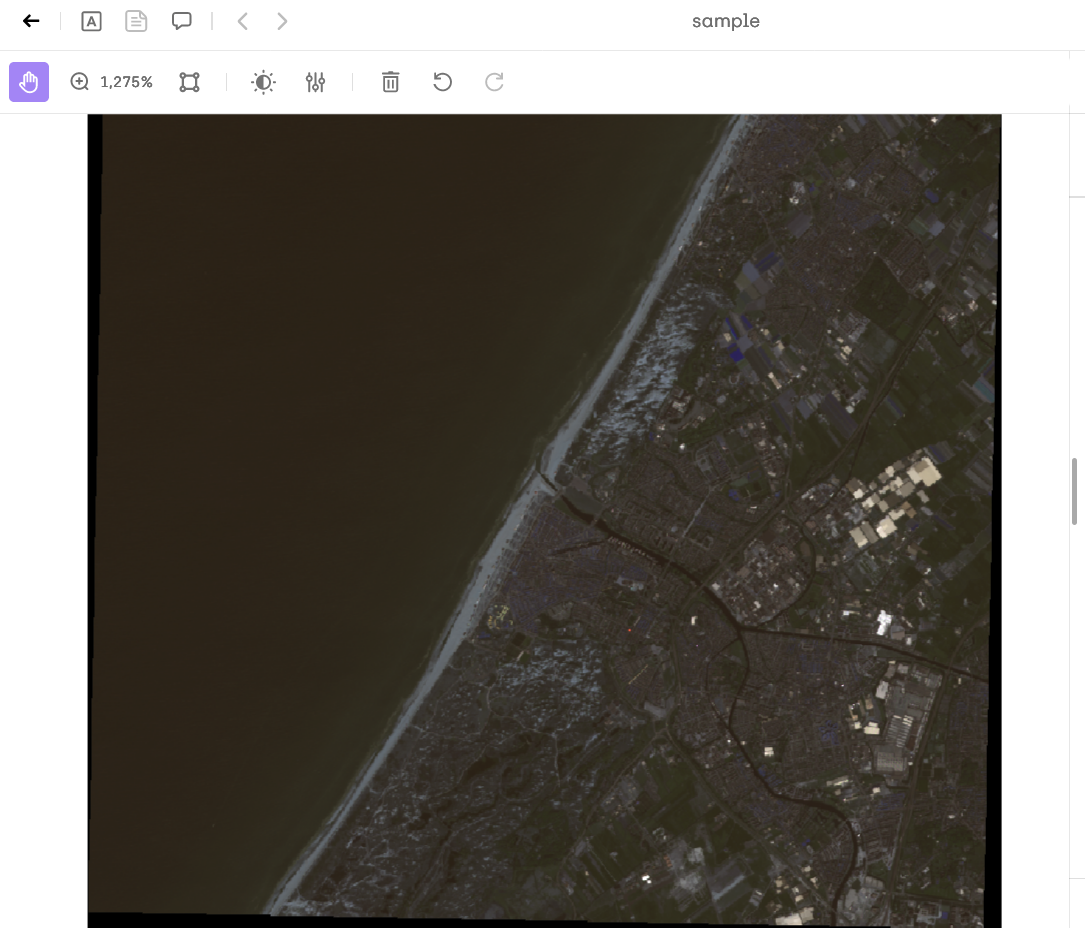

We can also visualize the same asset in geojson.io:

https://geojson.io/#map=11.98/52.2103/4.383

For sake of simplicity, we will assume that the asset has already been labeled in Kili. We will download the label and convert them to GeoJSON.

In [ ]:
!wget https://raw.githubusercontent.com/kili-technology/kili-python-sdk/main/recipes/datasets/geojson_tutorial_labels.json -O geojson_tutorial_labels.txt

In [ ]:
with open("geojson_tutorial_labels.json") as f:
    json_response = json.load(f)

In [ ]:
kili.append_labels(
    json_response_array=[json_response], project_id=project_id, asset_external_id_array=["sample"]
)

100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


[{'id': 'clk158y0501h00k7918o30fkx'}]

We can see that the asset has been labeled with some geometries:

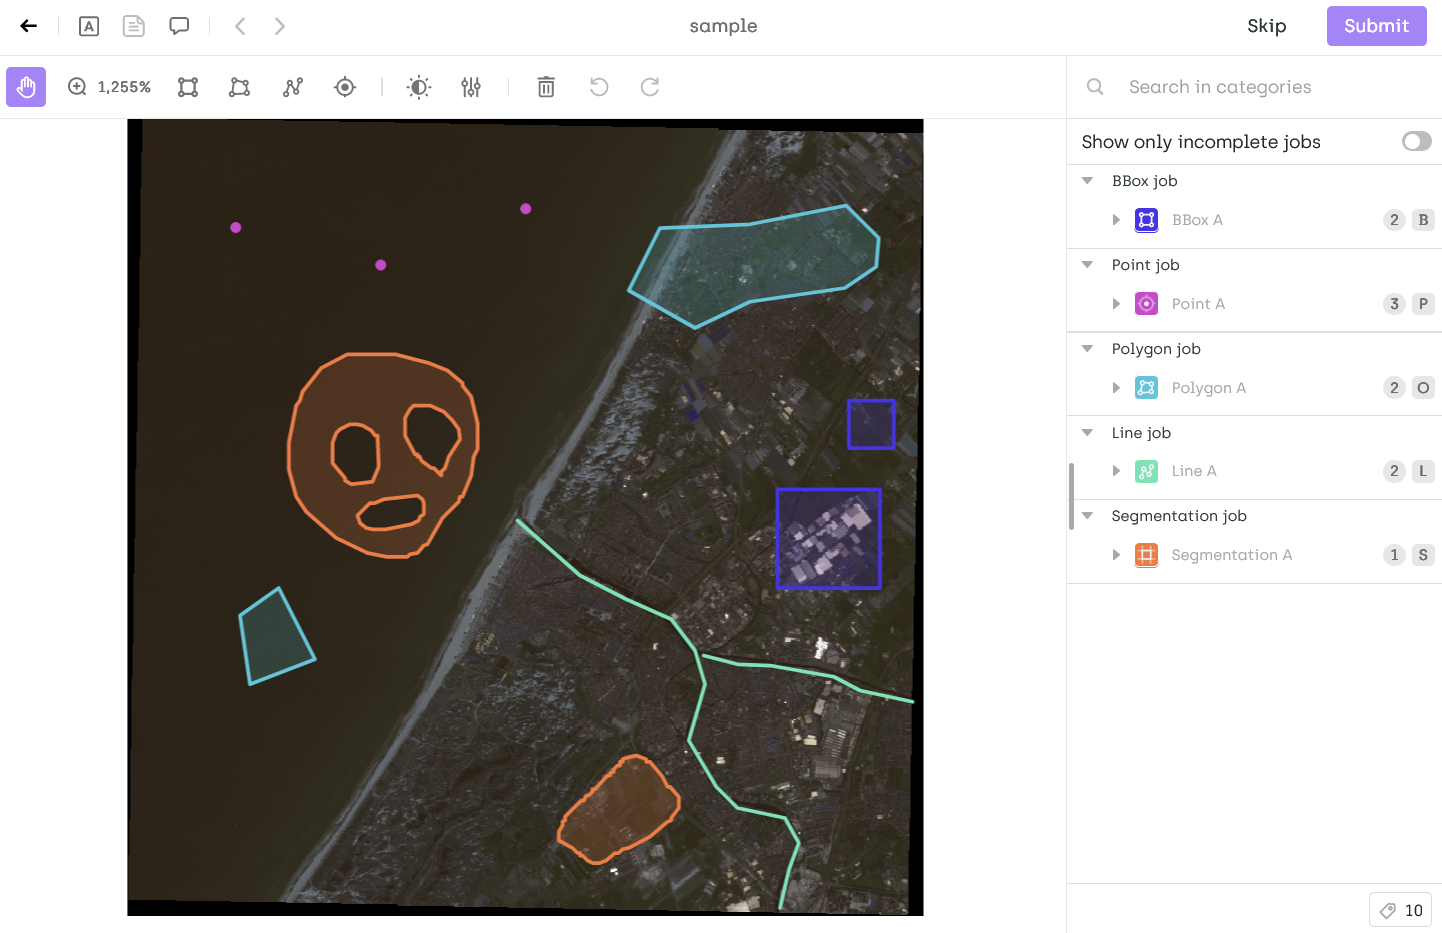

Remember that you can also use the Kili API to retrieve the label:

In [ ]:
label = kili.assets(
    project_id=project_id, fields=["latestLabel.jsonResponse"], label_output_format="parsed_label"
)[0]["latestLabel"]

100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


## Kili labels to GeoJSON

Kili SDK provides a set of label utils to convert Kili labels to GeoJSON:

In [ ]:
from kili.utils.labels.geojson import (
    features_list_to_feature_collection,
    kili_bbox_annotation_to_geojson_polygon_feature,
    kili_bbox_to_geojson_polygon,
    kili_line_annotation_to_geojson_linestring_feature,
    kili_line_to_geojson_linestring,
    kili_point_annotation_to_geojson_point_feature,
    kili_point_to_geojson_point,
    kili_polygon_annotation_to_geojson_polygon_feature,
    kili_polygon_to_geojson_polygon,
    kili_segmentation_annotation_to_geojson_polygon_feature,
    kili_segmentation_to_geojson_polygon,
)

Let's convert all annotations of this label to GeoJSON features:

In [ ]:
features = []

In [ ]:
for point_ann in label.jobs["POINT_DETECTION_JOB"].annotations:
    features.append(kili_point_annotation_to_geojson_point_feature(point_ann.as_dict()))

In [ ]:
for line_ann in label.jobs["LINE_DETECTION_JOB"].annotations:
    features.append(kili_line_annotation_to_geojson_linestring_feature(line_ann.as_dict()))

In [ ]:
for bbox_ann in label.jobs["BBOX_DETECTION_JOB"].annotations:
    features.append(kili_bbox_annotation_to_geojson_polygon_feature(bbox_ann.as_dict()))

In [ ]:
for polygon_ann in label.jobs["POLYGON_DETECTION_JOB"].annotations:
    features.append(kili_polygon_annotation_to_geojson_polygon_feature(polygon_ann.as_dict()))

In [ ]:
for segmentation_ann in label.jobs["SEGMENTATION_JOB"].annotations:
    features.append(
        kili_segmentation_annotation_to_geojson_polygon_feature(segmentation_ann.as_dict())
    )

Finally, we convert all features into a FeatureCollection:

In [ ]:
feature_collection = features_list_to_feature_collection(features)
with open("feature_collection.json", "w") as f:
    json.dump(feature_collection, f)

And we can visualize the GeoJSON file with our annotations by uploading it to [geojson.io]([geojson.io](https://geojson.io/#map=11.33/52.2094/4.4093)):

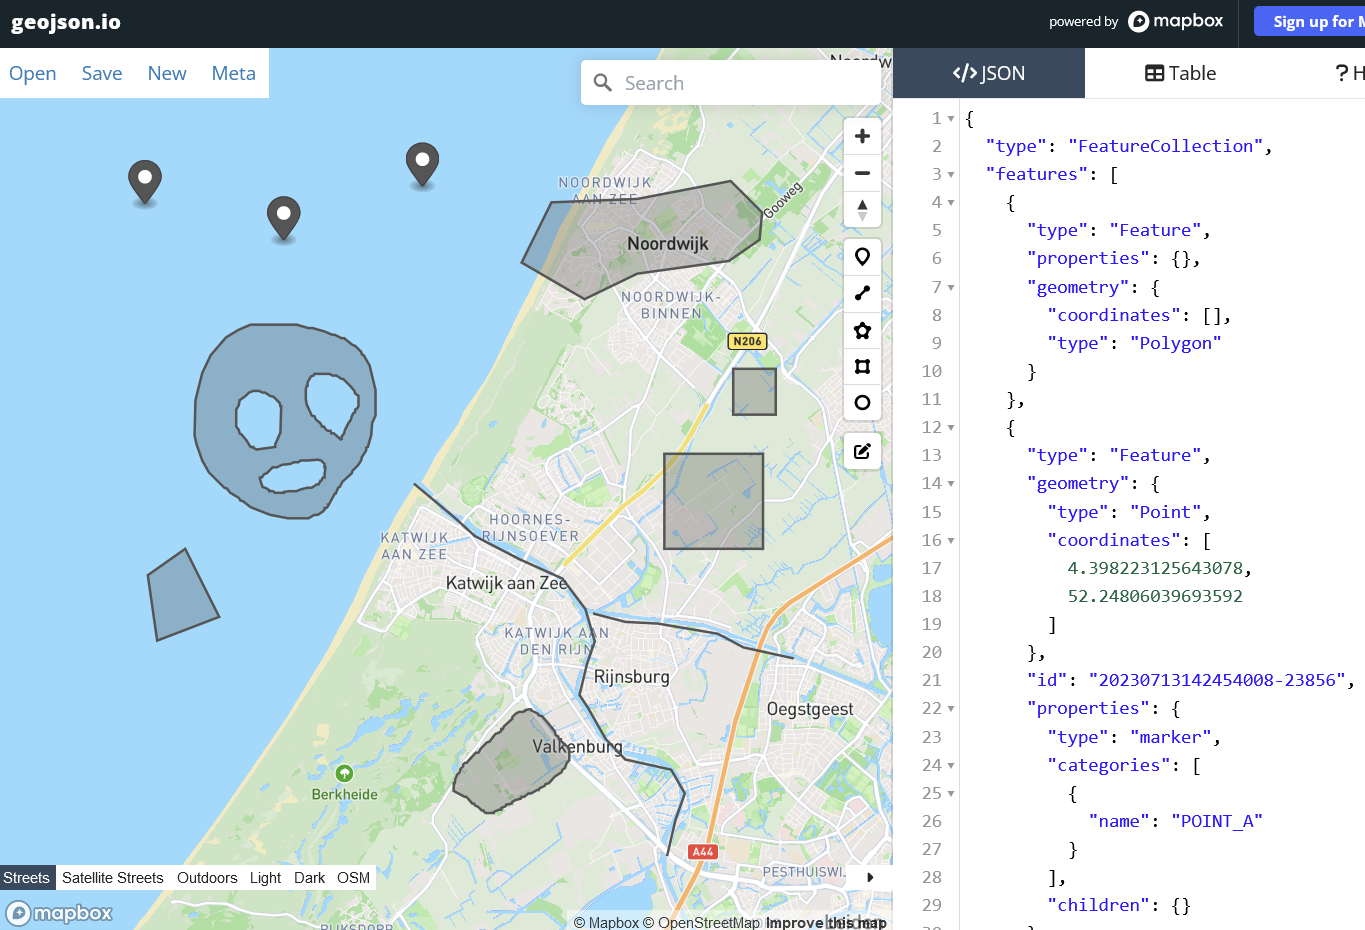

## GeoJSON to Kili labels